In [17]:
import cv2
import numpy as np
import onnxruntime as ort
from collections import deque
from modelArc import CRNN
from itertools import groupby
from matplotlib import pyplot as plt
from skimage.filters import threshold_local
import torch

def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

def preprocess_image(image):
    # Load the image using OpenCV
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(image, (3,3), 0)
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 4)
    # thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    # Morph open to remove noise and invert image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    # invert = 255 - opening

    return opening

def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

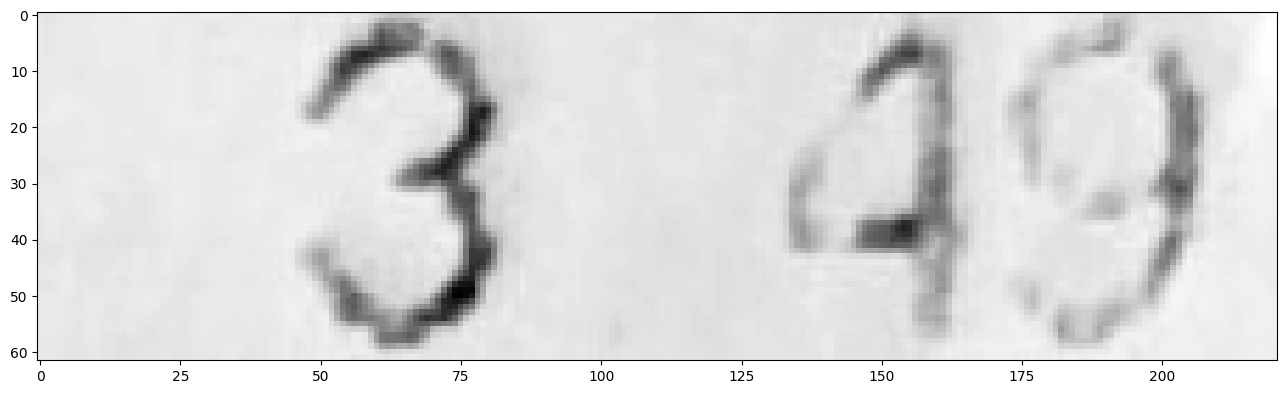

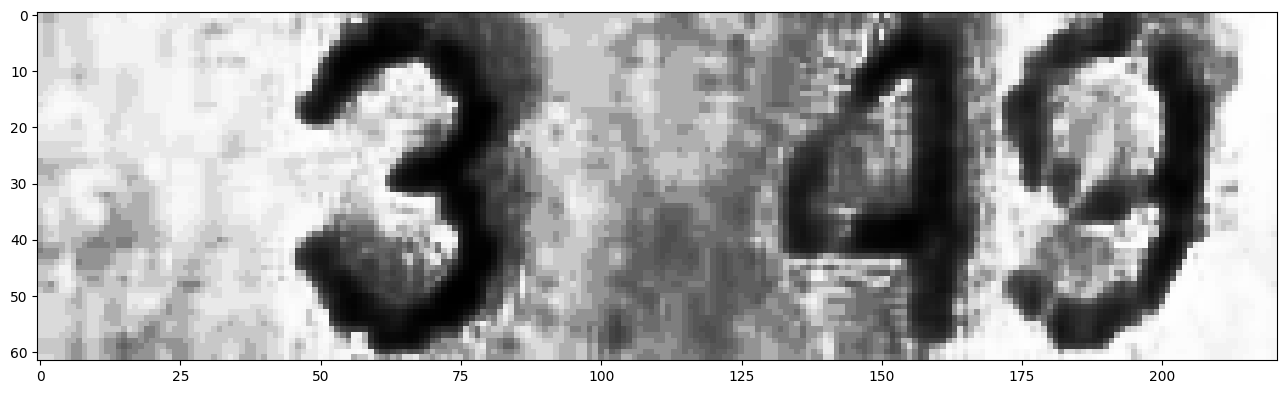

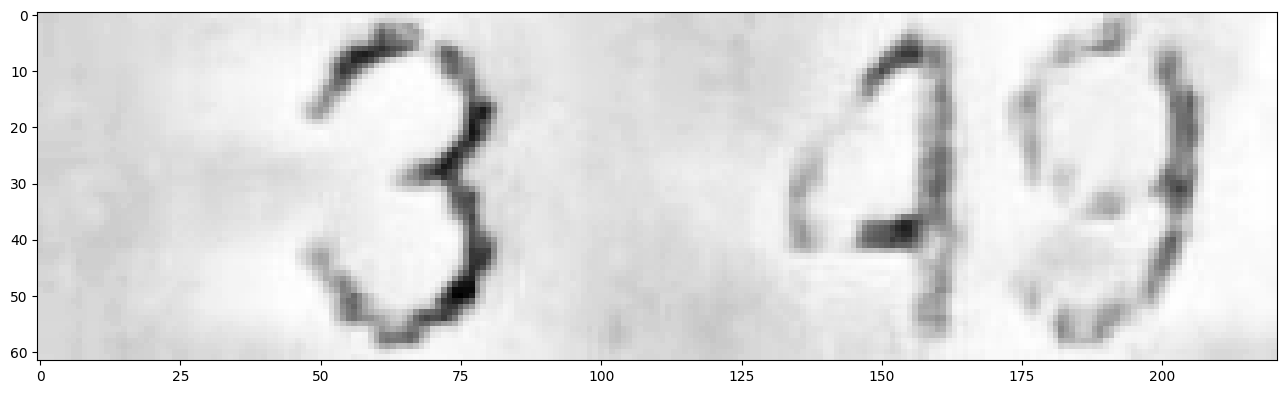

In [4]:
p = r"D:\photos\RCNN4\Lines\263-3.jpg"
testing = cv2.imread(p)
# display = bw_scanner(testing)
orig = cv2.cvtColor(testing, cv2.COLOR_BGR2GRAY)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_gray = clahe.apply(orig)

display = cv2.equalizeHist(orig)
# display = preprocess_image(testing)
plot_gray(orig)
plot_gray(display)
plot_gray(enhanced_gray)

In [65]:
model_path = r"D:\Projects\reciept-scanner\RCNN\models\GREYsuper\modelBIG69.onnx"

class inferencemode:
    def __init__(self, model_path: str = ""):
        self.model_path = model_path.replace("\\", "/")
        providers = ["CUDAExecutionProvider", "CPUExecutionProvider"] if ort.get_device() == "GPU" else ["CPUExecutionProvider"]

        self.model = ort.InferenceSession(model_path, providers = providers)

        self.metadata = {}
        for key, value in self.model.get_modelmeta().custom_metadata_map.items():
            new_value = value
            self.metadata[key] = new_value

        self.input_shapes = [meta.shape for meta in self.model.get_inputs()]
        self.input_names = [meta.name for meta in self.model._inputs_meta]
        self.output_names = [meta.name for meta in self.model._outputs_meta]

    def resize_maintaining_aspect_ratio(self, image: np.ndarray, width_target: int = 224, height_target: int = 36, padding_color: int=0) -> np.ndarray:

        height, width = image.shape[:2]
        ratio = min(width_target / width, height_target / height)
        new_w, new_h = int(width * ratio), int(height * ratio)

        resized_image = cv2.resize(image, (new_w, new_h))
        delta_w = width_target - new_w
        delta_h = height_target - new_h
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)

        new_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)

        return new_image
    def bw_scanner(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        T = threshold_local(gray, 21, offset = 5, method = "gaussian")
        return (gray > T).astype("uint8") * 255

    def preprocess(self, image: np.ndarray):
        # Load the image using OpenCV
        im = bw_scanner(image)
        blur = cv2.GaussianBlur(im, (3,3), 0)

        thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
        invert = 255 - opening

        return invert

    def predict(self, image: np.ndarray):
        resized_img = self.resize_maintaining_aspect_ratio(image)

        image_pred = np.expand_dims(resized_img, axis=0).astype(np.float32)
        image_pred = np.expand_dims(image_pred, axis=1)

        preds = self.model.run(self.output_names, {self.input_names[0]: image_pred})[0]

        #highest prob
        argmax_preds = np.argmax(preds, axis=-1)
        grouped_preds = [[k for k,_ in groupby(preds)] for preds in argmax_preds]
        texts = ["".join([self.metadata["vocab"][k] for k in group if k < len(self.metadata["vocab"])]) for group in grouped_preds]
        text = texts[0]

        return text
    
    def run(self, image: np.ndarray, bbox_coords: list): #list of format [[xmin, xmax, ymin, ymax], [xmin, xmax, ymin, ymax], [xmin, xmax, ymin, ymax],....]
        bboxes = []
        for i, (x_min, x_max, y_min, y_max) in enumerate(bbox_coords):
            box = image[y_min:y_max, x_min:x_max,]
            bboxes.append(box)
        
        results = []
        for b in bboxes:

            plt.figure(figsize=(10, 2))
            plt.imshow(b, cmap='gray')

            boxing_image = self.preprocess(b)
            prediction_image = cv2.cvtColor(b, cv2.COLOR_BGR2GRAY)
            img_height, img_width = boxing_image.shape[:2]

            minWidth = int(img_width * 0.05)
            minHeight = int(img_height * 0.25)
            minContourArea = int(img_width * img_height * 0.0015)

            # cv2.cvtColor(b, cv2.COLOR_BGR2GRAY)
            _, binary_image = cv2.threshold(boxing_image, 128, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
            kernel = np.ones((3, 17), np.uint8)
            dilated_image = cv2.dilate(binary_image, kernel, iterations=2)

            start_x = img_width * 3 // 4 
            roi = dilated_image[:, start_x:]
            kernel = np.ones((5, 36), np.uint8)
            dilated_roi = cv2.dilate(roi, kernel, iterations=1)
            dilated_image[:, start_x:] = dilated_roi

            contours, _ = cv2.findContours(dilated_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            filtered_contours = [c for c in contours if cv2.contourArea(c) > minContourArea]
            bounding_boxes = [cv2.boundingRect(c) for c in filtered_contours]
            bounding_boxes = sorted(bounding_boxes, key=lambda x: x[1])

            elements = []
            for i, (x, y, w, h) in enumerate(bounding_boxes):
                if w > minWidth and h> minHeight:
                    line_image = prediction_image[y:y+h, x:x+w]
                    elements.append(line_image)

            text = []
            for capture in elements:
                prediction_text = self.predict(capture)
                text.append(prediction_text)
            results.append(text)

            for (x, y, w, h) in bounding_boxes:
                if w > minWidth and h> minHeight:
                    cv2.rectangle(b, (x, y), (x+w, y+h), (0, 255, 0), 2)
            # Plot the image with bounding boxes
            plt.figure(figsize=(10, 2))
            plt.imshow(b, cmap='gray')
            plt.title('Detected Lines')
            plt.axis('off')
            plt.show()
            print(text)
        return results #results is a [[item: str], [item: str], [item: str], [item: str]....]

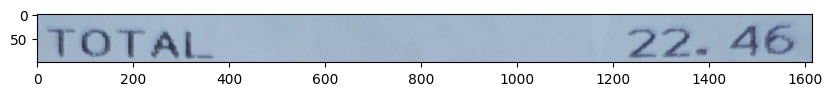

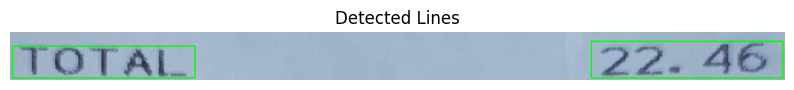

['22.46', 'TOTAL']


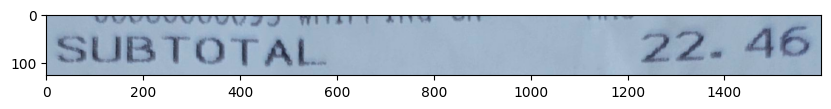

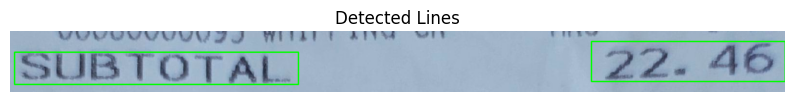

['22.46', 'SUB TOTAL']


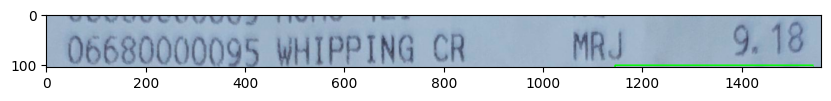

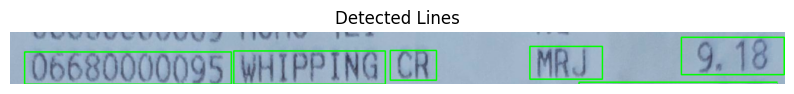

['9.18', 'MRU', 'CR', 'WHIPING', '066680000095']


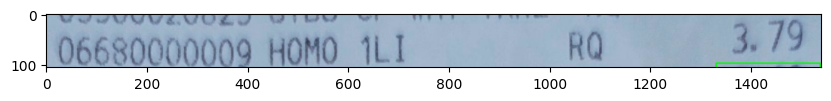

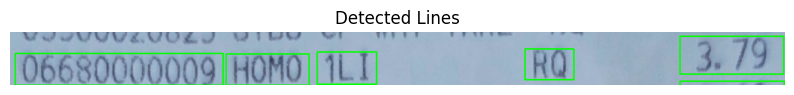

['3.79', 'R0', '1LL', '066690000009', 'HONQ']


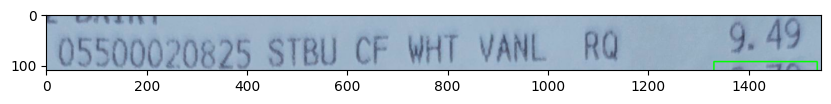

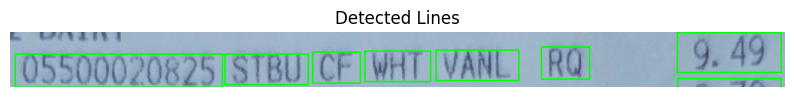

['9.49', 'R0', 'WANL', 'WMT', 'CR', 'STBU', '055000200825']
['22.46', 'TOTAL']
['22.46', 'SUB TOTAL']
['9.18', 'MRU', 'CR', 'WHIPING', '066680000095']
['3.79', 'R0', '1LL', '066690000009', 'HONQ']
['9.49', 'R0', 'WANL', 'WMT', 'CR', 'STBU', '055000200825']


In [66]:
#overall function
# testing
bboxCoord = [[105, 1720, 1415, 1515], [105, 1705, 1235, 1360], [160, 1720, 1155, 1260], [180, 1720, 1070, 1175], [180, 1725, 985, 1095]]
mean = 198.89307
std = 105.63787
img_path = r"D:\photos\RCNN4\train\20240706_015503_jpg.rf.480d069b4a243d281112d1daf06b8862.jpg"
image = cv2.imread(img_path.replace("\\", "/"))
# img = bw_scanner(image)
# print(img.shape)

tester = inferencemode(model_path)

results = tester.run(image, bboxCoord)
for i in results:
    print(i)


In [62]:
img_path = r"D:\photos\RCNN4\BBOXES\75.jpg"
img_path = r"D:\photos\SORIE\test\0afc0804-7e6e-4e77-ab68-8d9384918be7.jpg"
img_path = r"D:\photos\SORIE\test\000b7973-43d8-4071-bcdd-0274f6422771.jpg"
img_path = r"D:\photos\RCNN4\Lines\76-0.jpg"


image = cv2.imread(img_path.replace("\\", "/"))#np array
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
model = inferencemode(model_path)
prediction_text = model.predict(image)
print(f"Prediction is: {prediction_text}")

Prediction is: ORANGB)


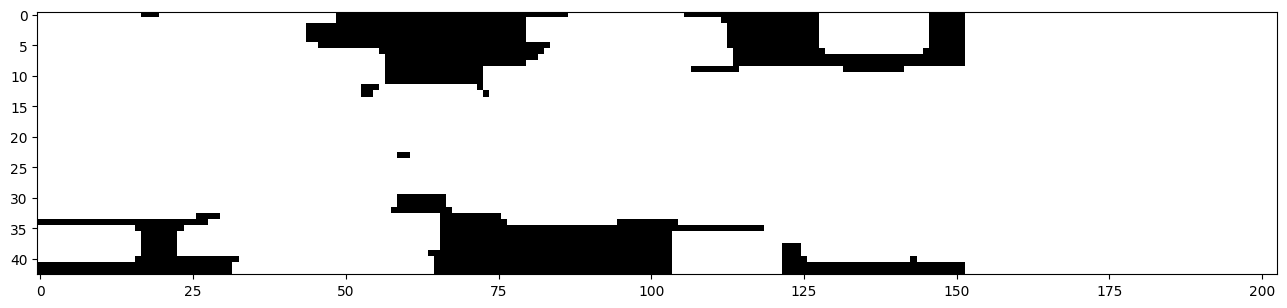

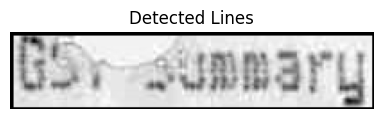

Prediction is: GST SUMMARY


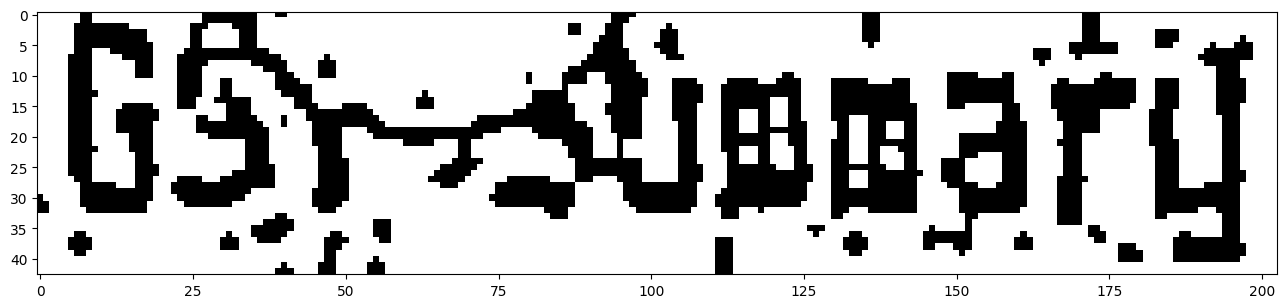

In [45]:
img_path = r"D:\photos\RCNN4\BBOXES\95.jpg"
img_path = r"D:\photos\RCNN_new_data\bboxes\items\1141.jpg"
img_path = r"D:\photos\SORIE\train\f3652815-bdf8-43f3-b017-093e99cee5fa.jpg"
img_path = r"D:\photos\RCNN4\BBOXES\8.jpg"
img_path = r"D:\photos\RCNN4\BBOXES\70.jpg"
img_path = r"D:\photos\SORIE\train\3acc20c2-462e-42e9-b6e4-7c706f730e40.jpg"

image = cv2.imread(img_path.replace("\\", "/"))#np array
img_height, img_width = image.shape[:2]

minWidth = int(img_width * 0.05)
minHeight = int(img_height * 0.25)
minContourArea = int(img_width * img_height * 0.0015)

orig = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

image = bw_scanner(image)
image_finder = preprocess_image(image)

_, binary_image = cv2.threshold(image_finder, 128, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
kernel = np.ones((3, 16), np.uint8)
dilated_image = cv2.dilate(binary_image, kernel, iterations=1)

start_x = img_width * 3 // 4 
roi = dilated_image[:, start_x:]
kernel = np.ones((5, 36), np.uint8)
dilated_roi = cv2.dilate(roi, kernel, iterations=1)
dilated_image[:, start_x:] = dilated_roi

plot_gray(dilated_image)
contours, _ = cv2.findContours(dilated_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

filtered_contours = [c for c in contours if cv2.contourArea(c) > minContourArea]

bounding_boxes = [cv2.boundingRect(c) for c in filtered_contours]
bounding_boxes = sorted(bounding_boxes, key=lambda x: x[1])

elements = []
for i, (x, y, w, h) in enumerate(bounding_boxes):
    if w > minWidth and h>minHeight:
        line_image = image_finder[y:y+h, x:x+w]
        elements.append(line_image)

model = inferencemode(model_path)
for (x, y, w, h) in bounding_boxes:
    if w > minWidth and h>minHeight:
        cv2.rectangle(orig, (x, y), (x+w, y+h), (0, 255, 0), 2)
# Plot the image with bounding boxes
plt.figure(figsize=(5, 1))
plt.imshow(orig, cmap='gray')
plt.title('Detected Lines')
plt.axis('off')
plt.show()

for capture in elements:
    plot_gray(capture)
    prediction_text = model.predict(capture)
    print(f"Prediction is: {prediction_text}")